# 3. Extracción Automatizada de Texto desde PDFs con Asociación de Metadatos para Normativas
Este script forma parte de la etapa de recopilación y estructuración de datos en una metodología basada en RAG (Retrieval-Augmented Generation). Extrae contenido de normativas legales en PDF y lo vincula con su metadata, generando una base consolidada y trazable. Este proceso permite convertir documentos no estructurados en información analizable, clave para evaluar su relevancia y facilitar búsquedas inteligentes en fases posteriores del sistema.

In [1]:
# library
import pandas as pd
from pathlib import Path
from pdfminer.high_level import extract_text
import matplotlib.pyplot as plt
import seaborn as sns
import tiktoken
import re
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS
import IPython.display as display
import os
from collections import Counter
from matplotlib.ticker import FuncFormatter

In [2]:
# -------------------------------
# CONSTANTS
# -------------------------------

CUSTOM_PALETTE = [
    "#677023",  # Olive Green
    "#F3A7CC",  # Bubblegum Pink
    "#5B6E86",  # Steel Blue
    "#FF5C73",  # Hot Coral
    "#B2A2D6",  # Cool Lilac
    "#DBFF00",  # Neon Lime
    "#FFB300",  # Golden Yellow
    "#212121",  # Deep Charcoal
    "#FEF9ED",  # Light Pink
    "#B4FF00",  # Lime Boots
    "#F9DA00",  # Yellow Suit
    "#DAB9CE",  # Mauve Shadow
    "#FFEDD6",  # Peach Cloud
    "#3D8B84",  # Deep Teal
    "#D1B660"   # Golden Moon
]
DATA_DIR = "./../raw_data"  # Directory where the PDFs and CSVs are stored
CSV_PATH = f"{DATA_DIR}/combined_regulations.csv"
PDF_DIR = Path(f"{DATA_DIR}/pdfs")
OUTPUT_COMPLETE_CSV = f"{DATA_DIR}/complete_regulations.csv"
OUTPUT_CLEAN_CSV_PATH = f"{DATA_DIR}/clean_regulations.csv"
OUTPUT_CLASSIFICATION_CSV = f"{DATA_DIR}/classified_regulations.csv"
SUFFIX = ""

TARGET_YEARS = [2020, 2021, 2022, 2023,2024,2025]  # Years to filter the regulations
TARGET_TYPES = ['circular', 'resolution']


In [ ]:
# -------------------------------
# FUNCTIONS
# -------------------------------
def extract_pdf_text(pdf_path):
    """
    Extracts and returns plain text from a given PDF file path.

    - Uses pdfminer.six's extract_text function
    - Strips leading and trailing whitespace from the result
    - Handles exceptions gracefully and returns None if extraction fails

    Parameters:
        pdf_path (str or Path): Path to the PDF file.

    Returns:
        str or None: Extracted text as a string, or None if an error occurred.
    """
    try:
        texto = extract_text(pdf_path)
        return texto.strip()
    except Exception as e:
        print(f"❌ Error while processing {pdf_path}: {e}")
        return None

# -------------------------------
# FUNCTION: ANALYZE TOKEN COUNTS
# -------------------------------
def analyze_tokens(csv_path, text_column='corpus',filter=None,color=0):
    """
    Analyzes the number of tokens per document in a given CSV file.

    - Loads a CSV file and verifies the specified text column exists
    - Uses OpenAI-compatible tokenizer (cl100k_base for GPT-4/gpt-3.5)
    - Calculates token counts per document
    - Plots a histogram of token distribution
    - Highlights documents above the 99th percentile as potential outliers

    Parameters:
        csv_path (str): Path to the CSV file to analyze
        text_column (str): Name of the column containing the text to tokenize

    Returns:
        pd.DataFrame: Original dataframe with a new column `n_tokens`
    """
    # ---------- LOAD ----------
    df = pd.read_csv(csv_path)

    if filter is not None:
        df = df[
            df['anno'].isin(TARGET_YEARS) 
        ]

    if text_column not in df.columns:
        raise ValueError(f"Column '{text_column}' not found in the file.")

    # ---------- TOKENIZER ----------
    tokenizer = tiktoken.get_encoding("cl100k_base")  # GPT-4 / gpt-3.5-turbo compatible

    def count_tokens(text):
        try:
            return len(tokenizer.encode(str(text)))
        except:
            return 0

    # ---------- TOKEN COUNT ----------
    df['n_tokens'] = df[text_column].fillna("").apply(count_tokens)

    # ---------- STATISTICS ----------
    print("\n📊 Token distribution statistics:")
    print(df['n_tokens'].describe())

    # ---------- HISTOGRAM ----------
    plt.figure(figsize=(10, 5))
    sns.histplot(df['n_tokens'], bins=30, kde=True, color=CUSTOM_PALETTE[color])  # Apply your palette color here
    plt.title("Frecuencia de Distribución de Tokens por Documento", fontsize=14)
    plt.xlabel("Número de Tokens")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---------- OUTLIER DETECTION ----------
    upper_threshold = df['n_tokens'].quantile(0.99)
    df_outliers = df[df['n_tokens'] > upper_threshold]
    print(f"\n📌 Documentos sobre el percentil 99 (> {int(upper_threshold)} tokens):")
    print(df_outliers[['nombre', 'n_tokens']] if 'nombre' in df.columns else df_outliers[['n_tokens']])

    return df

def advanced_cleaning(text):
    """
    Applies advanced cleaning to raw OCR text from normative documents.
    - Removes common headers, footers, legal references
    - Normalizes whitespace and removes special characters
    """
    text = text.lower()
    patterns_to_remove = [
        r'servicio de impuestos internos',
        r'santiago, \d{1,2} de [a-z]+ del \d{4}',
        r'resolución exenta sii n[°º] \d+.*',
        r'circular n[°º] \d+.*',
        r'subdirección de .*',
        r'departamento de .*',
        r'director(a)? del servicio.*',
        r'firmado electrónicamente por.*',
        r'este documento ha sido firmado.*',
        r'distribúyase.*',
        r'este documento es copia fiel.*',
        r'esta resolución reemplaza.*',
        r'esta circular modifica.*',
        r'página \d+ de \d+',
        r'https?://\S+',
    ]
    for pattern in patterns_to_remove:
        text = re.sub(pattern, '', text)

    text = re.sub(r'[^\w\sáéíóúüñ]', '', text)  # Remove non-word characters
    text = re.sub(r'\n+', '\n', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def trim_to_relevant_part(text):
    """
    Trims the text to its most relevant section, starting from specific keywords.
    Keeps the full body if no keyword is found.
    """
    text = text.lower()
    start_patterns = [
        r'\bconsiderando\b',
        r'\binstrucciones\b',
        r'\bresuelvo\b',
        r'\binstrucción general\b',
        r'\binstrucción específica\b',
    ]
    for pattern in start_patterns:
        match = re.search(pattern, text)
        if match:
            return text[match.start():]
    return text

def classify_relevance_weighted(row, glosas, keywords):
    """
    Classifies a document as relevant or not, based on pattern hits.
    """
    text = f"{row.get('nombre', '')} {row.get('descripcion', '')} {row.get('fuente', '')} {row.get('corpus', '')}".lower()

    match_count = 0
    explanations = []

    for pattern, reason in glosas:
        if re.search(pattern, text):
            match_count += 1
            explanations.append(f":Patrón encontrado: {reason}")

    for keyword, reason in keywords:
        if re.search(rf"(?<!\w){re.escape(keyword)}(?!\w)", text):
            match_count += 1
            explanations.append(f"Clave encontrada: {reason}")

    if match_count > 0:
        return "Relevante", " | ".join(explanations), match_count
    else:
        return "No Relevante", "No se encontraron reglas de negocio", match_count

def color_by_word(word, font_size, position, orientation, random_state=None, **kwargs):
    WORD_COLOR_MAP = dict(zip(most_common_words, CUSTOM_PALETTE))
    return WORD_COLOR_MAP.get(word.lower(), "#677023")  # Default olive green for unassigned

def thousands_formatter(x, pos):
    return f'{int(x/1000):,}'


## 3.1 Consolidación y Exportación del Corpus

En esta sección se recorren todos los archivos PDF disponibles y se extrae su contenido textual utilizando una función de OCR.

Para cada documento, se verifica si existe una entrada correspondiente en el archivo de metadatos (`df_meta`) y se construye un diccionario con los campos relevantes, incluyendo el texto completo (`corpus`).

Finalmente, se consolida toda la información en un nuevo DataFrame (`df_records`) y se exporta como archivo CSV en la ruta especificada por `OUTPUT_COMPLETE_CSV`.


In [4]:
# -------------------------------
# LOAD AND FILTER METADATA
# -------------------------------
df_meta = pd.read_csv(CSV_PATH)
df_meta.set_index('nombre_archivo', inplace=True)  # Use file_name as index

df = df_meta[
    df_meta['anno'].isin(TARGET_YEARS) &
    df_meta['tipo_documento'].str.lower().isin(TARGET_TYPES)
]
df.describe()

,anno
count,351.000000
mean,2022.250712
std,1.707075
min,2020.000000
25%,2021.000000
50%,2022.000000
75%,2024.000000
max,2025.000000


In [ ]:
# -------------------------------
# PDF TEXT EXTRACTION AND RECORD CONSOLIDATION
# -------------------------------
records = []
pdf_files = list(PDF_DIR.glob("*.pdf"))

for pdf_file in tqdm(pdf_files, desc="Processing PDFs"):
    file_stem = pdf_file.stem  # Filename without .pdf extension

    text = extract_pdf_text(pdf_file)
    if not text:
        continue

    if file_stem in df_meta.index:
        row = df_meta.loc[file_stem]
        records.append({
            "nombre": row["nombre"],
            "descripcion": row["descripcion"],
            "fuente": row["fuente"],  # Make sure 'source' is normalized in df_meta
            "url": row["url"],
            "tipo_documento": row.get("tipo_documento", ""),
            "corpus": text,
            "origen": row.get("origen", ""),
            "anno": row.get("anno", ""),
        })
    else:
        records.append({
            "nombre": file_stem,
            "descripcion": "",
            "fuente": "",
            "url": "",
            "tipo_documento": "",
            "corpus": text,
            "origen": "",
            "anno": "",
        })

# -------------------------------
# EXPORT TO CSV
# -------------------------------
df_records = pd.DataFrame(records)
df_records.to_csv(OUTPUT_COMPLETE_CSV + SUFFIX, index=False, encoding='utf-8-sig')
print(f"\n✅ File generated: {OUTPUT_COMPLETE_CSV + SUFFIX} with {len(df_records)} documents.")


## 3.2 Análisis Exploratorio de Longitud de Documentos
Este script corresponde a la etapa de diagnóstico exploratorio de los datos en el enfoque RAG. Permite visualizar la extensión de los documentos legales en términos de tokens, lo cual es esencial para tomar decisiones de preprocesamiento antes de su vectorización. Con esto, se identifican outliers que podrían afectar la calidad del modelo y se ajustan estrategias como limpieza, segmentación o exclusión para mejorar el desempeño del sistema.


📊 Token distribution statistics:
count      1161.000000
mean       4686.869940
std        7722.525066
min          65.000000
25%        1710.000000
50%        2854.000000
75%        4917.000000
max      139808.000000
Name: n_tokens, dtype: float64


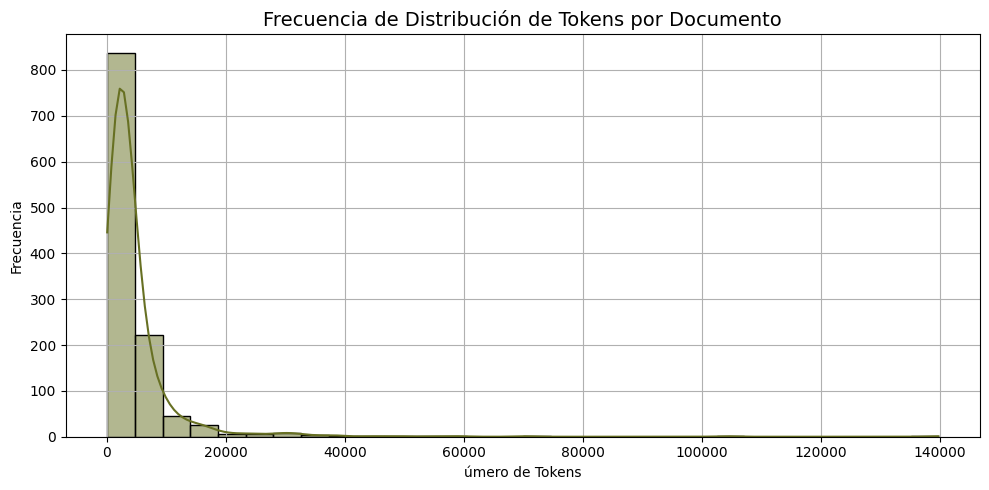


📌 Documentos sobre el percentil 99 (> 32645 tokens):
                                            nombre  n_tokens
245        Circular N° 19 del 06 de Marzo del 2025     34617
299    Circular N° 53 del 19 de Diciembre del 2024     33548
316         Circular N° 31 del 19 de Mayo del 2021     44257
318   Circular N° 62 del 24 de Septiembre del 2020    103999
331       Circular N° 35 del 04 de Agosto del 2022     38376
350        Circular N° 31 del 17 de Abril del 2025     36908
363    Circular N° 73 del 22 de Diciembre del 2020    139808
365        Circular N° 43 del 05 de Julio del 2021     54943
417        Circular N° 41 del 02 de Julio del 2021     48983
497      Circular N° 12 del 17 de Febrero del 2021     70387
737       Circular N° 53 del 10 de Agosto del 2020     59222
1037  Circular N° 56 del 04 de Septiembre del 2020     38654


In [6]:
df_before = analyze_tokens(OUTPUT_COMPLETE_CSV + SUFFIX, text_column='corpus', filter=TARGET_YEARS) 

## 3.3 Limpieza y reducción de ruido textual en normativas SII
Este proceso transforma los documentos legales en texto más claro y enfocado, eliminando encabezados, firmas y secciones repetitivas. Además, aplica reglas básicas de limpieza como eliminación de URLs, símbolos y espacios extra. Se conserva el sentido legal y se mejora la calidad semántica para tareas posteriores como clasificación o embeddings.

In [7]:
tqdm.pandas()
# -------------------------------
# VALIDATE REQUIRED COLUMNS
# -------------------------------
required_columns = ['corpus', 'tipo_documento']
for col in required_columns:
    if col not in df_before.columns:
        raise ValueError(f"Missing required column: '{col}'")



# -------------------------------
# APPLY CLEANING FUNCTIONS
# -------------------------------
df_before['corpus'] = df_before['corpus'].progress_apply(advanced_cleaning)
df_before['corpus'] = df_before['corpus'].progress_apply(trim_to_relevant_part)


# -------- Guardar el resultado --------
df_before.to_csv(OUTPUT_CLEAN_CSV_PATH + SUFFIX, index=False, encoding='utf-8-sig')
print(f"✅ Archivo limpio guardado como: {OUTPUT_CLEAN_CSV_PATH}+ SUFFIX")

100%|██████████| 1161/1161 [00:00<00:00, 12433.61it/s]


✅ Archivo limpio guardado como: ./../raw_data/clean_regulations.csv+ SUFFIX



📊 Token distribution statistics:
count      1161.000000
mean       2851.217054
std        5337.353755
min          37.000000
25%         904.000000
50%        1615.000000
75%        2633.000000
max      101943.000000
Name: n_tokens, dtype: float64


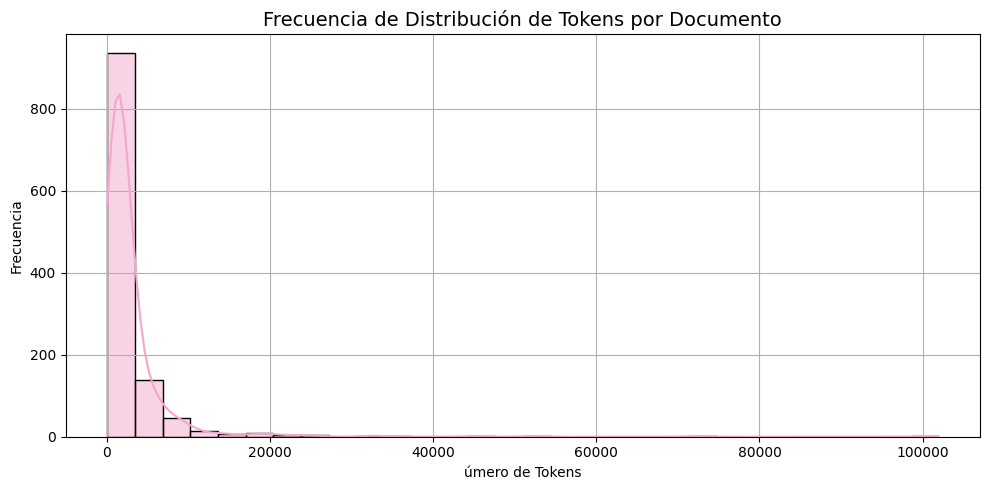


📌 Documentos sobre el percentil 99 (> 22191 tokens):
                                                 nombre  n_tokens
209             Circular N° 10 del 30 de Enero del 2025     23386
245             Circular N° 19 del 06 de Marzo del 2025     24698
299         Circular N° 53 del 19 de Diciembre del 2024     24726
316              Circular N° 31 del 19 de Mayo del 2021     31998
318        Circular N° 62 del 24 de Septiembre del 2020     71958
363         Circular N° 73 del 22 de Diciembre del 2020    101943
365             Circular N° 43 del 05 de Julio del 2021     34954
417             Circular N° 41 del 02 de Julio del 2021     32759
497           Circular N° 12 del 17 de Febrero del 2021     51513
737            Circular N° 53 del 10 de Agosto del 2020     44438
950   Resolución Exenta SII N° 106 del 06 de Septiem...     23241
1037       Circular N° 56 del 04 de Septiembre del 2020     25923


In [8]:
df_after = analyze_tokens(OUTPUT_CLEAN_CSV_PATH + SUFFIX, text_column='corpus',color=1) 

 Reducción total de tokens: 39.17%


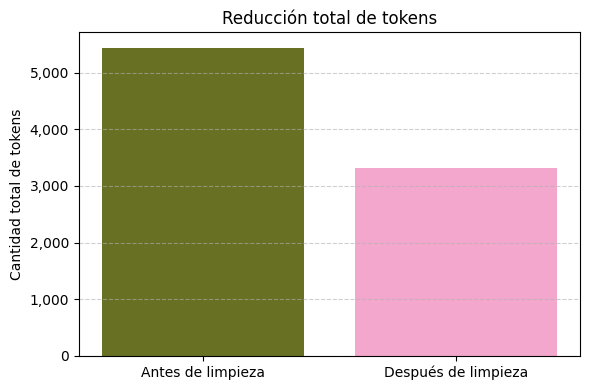

In [9]:
# df_before: corpus original
# df_after: corpus limpio


total_before = df_before['n_tokens'].sum()
total_after = df_after['n_tokens'].sum()

reduction_pct = 100 * (total_before - total_after) / total_before
print(f" Reducción total de tokens: {reduction_pct:.2f}%")


totals = [df_before['n_tokens'].sum(), df_after['n_tokens'].sum()]
labels = ['Antes de limpieza', 'Después de limpieza']
plt.figure(figsize=(6, 4))

plt.bar(labels, totals, color=[CUSTOM_PALETTE[0], CUSTOM_PALETTE[1]])
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.title('Reducción total de tokens')
plt.ylabel('Cantidad total de tokens')
plt.tight_layout()
plt.show()



## 3.4 Clasificación Basada en Reglas de Negocio
Este paso corresponde a la etapa de etiquetado estratégico dentro del pipeline de análisis regulatorio. Utiliza criterios previamente definidos por expertos del dominio para determinar si una normativa es relevante o no. La clasificación se realiza examinando tanto el contenido como la metadata del documento, y se justifica con una explicación trazable. Este enfoque garantiza alineamiento con prioridades del negocio antes de aplicar modelos automatizados de mayor complejidad.

1. Clasificación basada en glosa

| Expresión regular (regex)                                               | Glosa asignada                     |
|-------------------------------------------------------------------------|------------------------------------|
| resolución\s+exenta\s+(n°\|número)?\s*176.*2020                         | Resolución 176 de 2020             |
| resolución\s+exenta\s+(n°\|número)?\s*76.*2021                          | Resolución 76 de 2021              |
| resolución\s+exenta\s+(n°\|número)?\s*79.*2025                          | Resolución 79 de 2025              |
| circular\s+(n°\|número)?\s*38.*2025                                     | Circular 38 de 2025                |
| artículo\s+68.*código tributario                                        | Artículo 68 del Código Tributario  |


2. Clasificación basada en palabra(s)

| Palabra clave                                                 | Descripción asignada                                              |
|---------------------------------------------------------------|-------------------------------------------------------------------|
| boleta                                                        | Contiene 'boleta'                                                 |
| boleta de venta                                               | Contiene 'boleta de venta'                                        |
| medio de pago                                                 | Contiene 'medio de pago'                                          |
| comprobante electrónico                                       | Contiene 'comprobante electrónico'                                |
| registro de compra                                            | Contiene 'registro de compra'                                     |
| registro de venta                                             | Contiene 'registro de venta'                                      |
| cumplimiento tributario                                       | Contiene 'cumplimiento tributario'                                |
| inicio de actividades                                         | Contiene 'inicio de actividades'                                  |
| medios de pago electrónicos                                   | Contiene 'medios de pago electrónicos'                            |
| pos                                                           | Contiene 'POS'                                                    |
| p.o.s                                                         | Contiene 'P.O.S'                                                  |
| puntos de venta                                               | Contiene 'puntos de venta'                                        |
| operadores                                                    | Contiene 'operadores'                                             |
| comercio electrónico                                          | Contiene 'comercio electrónico'                                   |
| psp                                                           | Contiene 'psp'                                                    |
| proveedores de servicios para procesamiento de pagos          | Contiene 'proveedores de servicios para procesamiento de pagos'   |
| no presencial                                                 | Contiene 'no presencial'                                          |
| pagos electrónicos                                            | Contiene 'pagos electrónicos'                                     |
| administrador de medio de pago                                | Contiene 'administrador de medios de pago'                                     |


In [10]:
tqdm.pandas()

df = pd.read_csv(OUTPUT_CLEAN_CSV_PATH + SUFFIX)

# --------------------
# REGLAS DE NEGOCIO
# --------------------
re_glosas = [
    (r"resolución\s+exenta\s+(n°|número)?\s*176.*2020", "Resolución 176 de 2020"),
    (r"resolución\s+exenta\s+(n°|número)?\s*76.*2021", "Resolución 76 de 2021"),
    (r"resolución\s+exenta\s+(n°|número)?\s*79.*2025", "Resolución 79 de 2025"),
    (r"circular\s+(n°|número)?\s*38.*2025", "Circular 38 de 2025"),
    (r"artículo\s+68.*código tributario", "Artículo 68 del Código Tributario"),
  
]

palabras_clave = [
    ("boleta", "Contiene 'boleta'"),
    ("boleta de venta", "Contiene 'boleta de venta'"),
    ("medio de pago", "Contiene 'medio de pago'"),
    ("comprobante electrónico", "Contiene 'comprobante electrónico'"),
    ("registro de compra", "Contiene 'registro de compra'"),
    ("registro de venta", "Contiene 'registro de venta'"),
    ("cumplimiento tributario", "Contiene 'cumplimiento tributario'"),
    ("inicio de actividades", "Contiene 'inicio de actividades'"),
    ("medios de pago electrónicos", "Contiene 'medios de pago electrónicos'"),
    ("pos", "Contiene 'POS'"),
    ("p.o.s", "Contiene 'P.O.S'"),
    ("puntos de venta", "Contiene 'puntos de venta'"),
    ("operadores", "Contiene 'operadores'"),
    ("comercio electrónico", "Contiene 'comercio electrónico'"),
    ("psp", "Contiene 'psp'"),
    ("proveedores de servicios para procesamiento de pagos", "Contiene 'proveedores de servicios para procesamiento de pagos'"),
    ("no presencial", "Contiene 'no presencial'"),
    ("pagos electrónicos", "Contiene 'pagos electrónicos'"),
    ("administrador de medio de pago", "Contiene 'administrador de medio de pago'"),
]

# --------------------
# APLICAR CLASIFICACIÓN
# --------------------
df[['relevancia', 'explicacion', 'exitos']] = df.progress_apply(
    lambda row: pd.Series(classify_relevance_weighted(row, glosas=re_glosas, keywords=palabras_clave)),
    axis=1
)

# --------------------
# EXPORTAR RESULTADO
# --------------------
df.to_csv(OUTPUT_CLASSIFICATION_CSV + SUFFIX, index=False, encoding='utf-8-sig')
print(f"✅ Archivo generado: {OUTPUT_CLASSIFICATION_CSV + SUFFIX} con columnas 'relevancia' y 'explicacion'.")

100%|██████████| 1161/1161 [00:03<00:00, 290.45it/s]


✅ Archivo generado: ./../raw_data/classified_regulations.csv con columnas 'relevancia' y 'explicacion'.



📊 Distribución de éxitos:
count    1161.000000
mean        0.394488
std         0.841450
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         8.000000
Name: exitos, dtype: float64


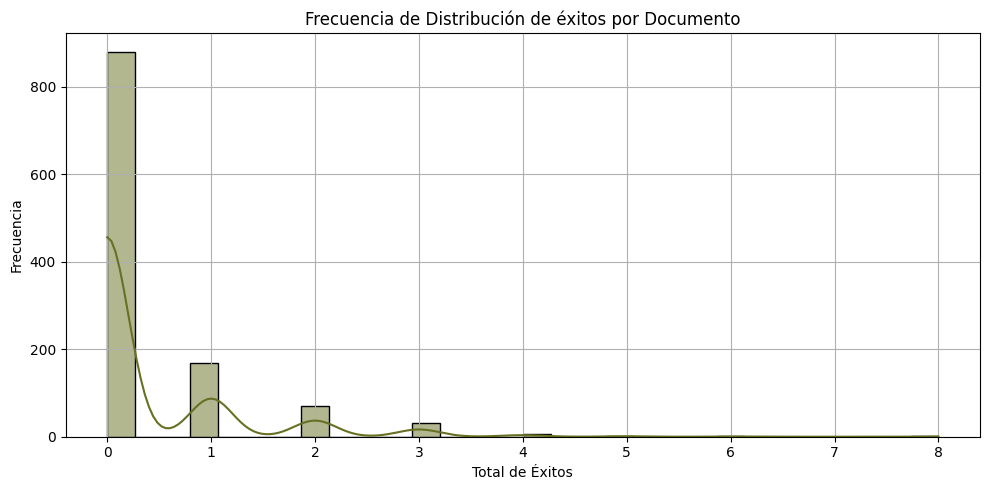


📌 Documentos sobre el percentil 99 (> 3 éxitos):
                                                 nombre  exitos
353   Resolución Exenta SII N° 76 del 06 de Julio de...       8
499             Circular N° 38 del 30 de Abril del 2025       6
43    Resolución Exenta SII N° 176 del 31 de Diciemb...       5
950   Resolución Exenta SII N° 106 del 06 de Septiem...       5
245             Circular N° 19 del 06 de Marzo del 2025       4
320   Resolución Exenta SII N° 12 del 17 de Enero de...       4
841   Resolución Exenta SII N° 77 del 26 de Junio de...       4
849   Resolución Exenta SII N° 79 del 26 de Junio de...       4
417             Circular N° 41 del 02 de Julio del 2021       4
631             Circular N° 33 del 17 de Abril del 2025       4
1077            Circular N° 42 del 11 de Junio del 2020       4


In [11]:
df.sort_values(by='exitos', ascending=False, inplace=True)
print("\n📊 Distribución de éxitos:")
print(df['exitos'].describe())
plt.figure(figsize=(10, 5))
sns.histplot(df['exitos'], bins=30, kde=True, color=CUSTOM_PALETTE[0])  # Apply your palette color here
plt.title("Frecuencia de Distribución de éxitos por Documento")
plt.xlabel("Total de Éxitos")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- OUTLIER DETECTION ----------
upper_threshold = df['exitos'].quantile(0.99)
df_outliers = df[df['exitos'] > upper_threshold]
print(f"\n📌 Documentos sobre el percentil 99 (> {int(upper_threshold)} éxitos):")
print(df_outliers[['nombre', 'exitos']] if 'nombre' in df.columns else df_outliers[['exitos']])


In [12]:
# -------------------------------
# TOP 10 DOCUMENTOS RELEVANTES
# -------------------------------
top_docs = df.sort_values(by='exitos', ascending=False).head(10)

# Mostrar columnas clave
cols_to_show = ['nombre', 'exitos', 'explicacion','anno']
top_docs_display = top_docs[cols_to_show].copy()

# Renombrar columnas para visualización más clara (puedes traducir si prefieres en inglés)
top_docs_display.columns = ['Nombre del Documento', 'Coincidencias', 'Explicación','Año']

display.display(top_docs_display)


,Nombre del Documento,Coincidencias,Explicación,Año
353,Resolución Exenta SII N° 76 del 06 de Julio de...,8,Clave encontrada: Contiene 'boleta' | Clave en...,2021
499,Circular N° 38 del 30 de Abril del 2025,6,:Patrón encontrado: Circular 38 de 2025 | :Pat...,2025
43,Resolución Exenta SII N° 176 del 31 de Diciemb...,5,Clave encontrada: Contiene 'boleta' | Clave en...,2020
950,Resolución Exenta SII N° 106 del 06 de Septiem...,5,Clave encontrada: Contiene 'medio de pago' | C...,2023
849,Resolución Exenta SII N° 79 del 26 de Junio de...,4,:Patrón encontrado: Artículo 68 del Código Tri...,2025
1077,Circular N° 42 del 11 de Junio del 2020,4,:Patrón encontrado: Artículo 68 del Código Tri...,2020
417,Circular N° 41 del 02 de Julio del 2021,4,:Patrón encontrado: Artículo 68 del Código Tri...,2021
631,Circular N° 33 del 17 de Abril del 2025,4,:Patrón encontrado: Artículo 68 del Código Tri...,2025
841,Resolución Exenta SII N° 77 del 26 de Junio de...,4,:Patrón encontrado: Artículo 68 del Código Tri...,2025
320,Resolución Exenta SII N° 12 del 17 de Enero de...,4,Clave encontrada: Contiene 'boleta' | Clave en...,2025


## 3.5 Análisis Exploratorio por Relevancia

En esta sección se realiza un análisis exploratorio de la variable `relevancia`, generada en etapas previas del procesamiento y clasificación de normativas. El objetivo es cuantificar y visualizar la distribución de los documentos según su nivel de relevancia, permitiendo así identificar la proporción de normativas consideradas relevantes frente a las no relevantes dentro del corpus procesado.

Este análisis resulta fundamental para evaluar el desempeño de las reglas de clasificación aplicadas y para obtener una visión general sobre el balance del dataset, lo cual es especialmente importante en tareas posteriores de modelado o entrenamiento supervisado. Se presentan estadísticas generales, tanto en conteo absoluto como en porcentaje, facilitando la interpretación y toma de decisiones en etapas siguientes del flujo de trabajo.


In [13]:
df = pd.read_csv(OUTPUT_CLASSIFICATION_CSV + SUFFIX)

# Asegurarse de que la columna 'relevancia' exista
if 'relevancia' not in df.columns:
    raise ValueError("⚠️ La columna 'relevancia' no está presente en el archivo.")

# -----------------------
# Estadísticas generales
# -----------------------
conteo = df['relevancia'].value_counts()
porcentaje = df['relevancia'].value_counts(normalize=True).round(2) * 100

print("📌 Conteo de documentos por relevancia:")
print(conteo)
print("\n📌 Porcentaje de documentos por relevancia:")
print(porcentaje)




📌 Conteo de documentos por relevancia:
relevancia
No Relevante    879
Relevante       282
Name: count, dtype: int64

📌 Porcentaje de documentos por relevancia:
relevancia
No Relevante    76.0
Relevante       24.0
Name: proportion, dtype: float64


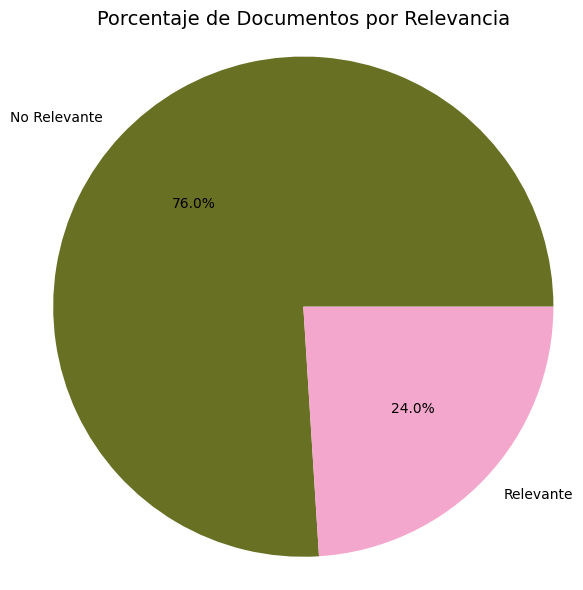

In [14]:
porcentaje = df['relevancia'].value_counts(normalize=True).round(2) * 100 
# Create pie chart
plt.figure(figsize=(6, 6))
labels = ['No Relevante', 'Relevante']
plt.pie(porcentaje, labels=labels, colors=[CUSTOM_PALETTE[0], CUSTOM_PALETTE[1]], autopct='%1.1f%%',
        )
plt.title('Porcentaje de Documentos por Relevancia', fontsize=14)
plt.axis('equal')  # Ensures the pie is a circle
plt.tight_layout()
plt.show()

In [15]:
# -----------------------
# Top fuentes emisoras de documentos relevantes
# -----------------------
if 'fuente' in df.columns:
    top_fuentes = df[df['relevancia'] == 'Relevante']['fuente'].value_counts().head(10)
    print("\n🏢 Top fuentes emisoras de documentos relevantes:")
    print(top_fuentes)


🏢 Top fuentes emisoras de documentos relevantes:
fuente
Subdireccion De Fiscalizacion                                 101
Subdireccion De Asistencia Al Contribuyente                    80
Subdireccion De Gestion Estrategica Y Estudios Tributarios     38
Subdireccion Normativa                                         18
Subdireccion Juridica                                          16
Direccion De Grandes Contribuyentes                             7
Subdireccion De Asuntos Corporativos                            6
Subdireccion De Avaluaciones                                    4
Impuestos Indirectos                                            2
Subdireccion De Desarrollo De Personas                          2
Name: count, dtype: int64


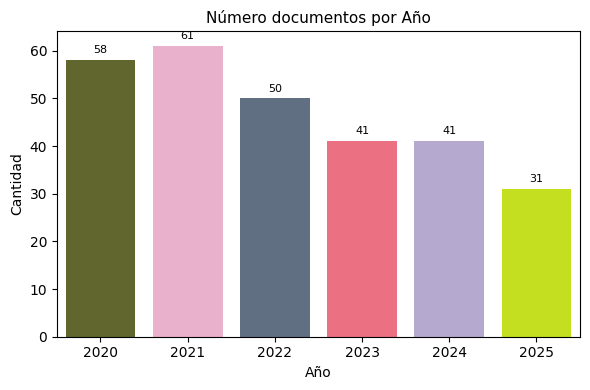

In [16]:
year_counts = df[df['relevancia'] == 'Relevante']['anno'].value_counts().sort_index()
plt.figure(figsize=(6, 4))

ax = sns.barplot(
    x=year_counts.index,
    y=year_counts.values,
    hue=year_counts.index.astype(str),  # hue obligatorio si usas palette
    palette=CUSTOM_PALETTE[:len(year_counts)],
    legend=False,
)
# Add values above each bar
for i, value in enumerate(year_counts.values):
    ax.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=8)

plt.title("Número documentos por Año", fontsize=11)
plt.xlabel("Año")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.show()

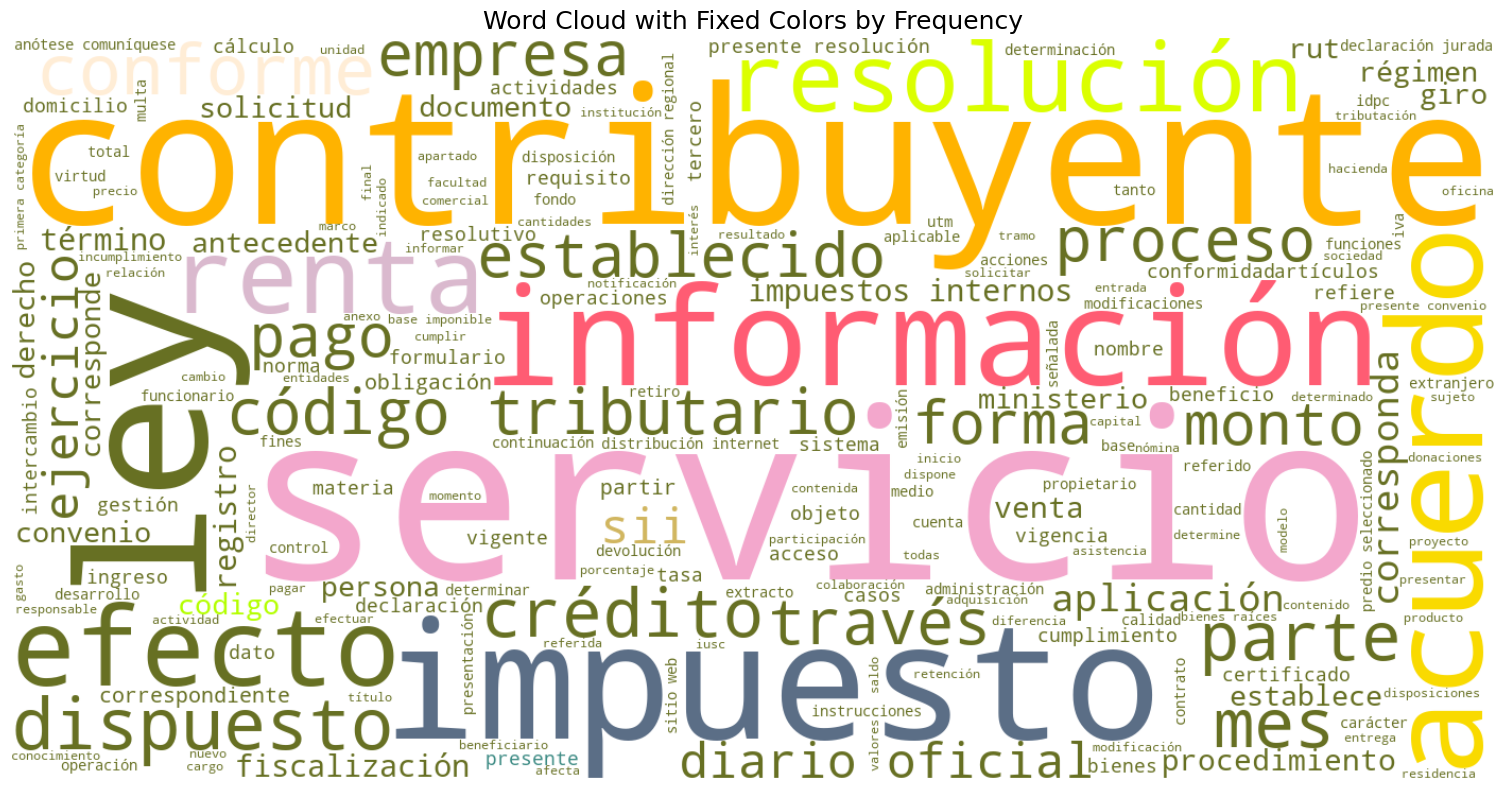

In [17]:
# Path to custom stopwords file
stopwords_path = f"{DATA_DIR}/stopwords.txt"
df = pd.read_csv(OUTPUT_CLASSIFICATION_CSV)
# Load custom stopwords if available
if os.path.exists(stopwords_path):
    with open(stopwords_path, encoding='latin1') as f:
        custom_stopwords = set(f.read().splitlines())
    stopwords = STOPWORDS.union(custom_stopwords)
else:
    print("⚠️ Custom stopwords file not found. Using default only.")
    stopwords = STOPWORDS

text_corpus = df['corpus'].dropna().astype(str).str.cat(sep=' ')

# ----------------------
# COLOR MAPPING SETUP
# ----------------------
words = text_corpus.split()
filtered_words = [w for w in words if w not in stopwords]
word_freq = Counter(filtered_words)

# Assign color to top N words based on CUSTOM_PALETTE
N = len(CUSTOM_PALETTE)
most_common_words = [word for word, _ in word_freq.most_common(N)]
WORD_COLOR_MAP = dict(zip(most_common_words, CUSTOM_PALETTE))

# ----------------------
# GENERATE WORD CLOUD
# ----------------------
wordcloud = WordCloud(
    width=1400,
    height=700,
    background_color='white',
    stopwords=stopwords,
    colormap='viridis',
    max_words=200
).generate(text_corpus)

wordcloud.recolor(color_func=color_by_word)

# ----------------------
# PLOT
# ----------------------
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud with Fixed Colors by Frequency", fontsize=18)
plt.tight_layout()
plt.show()

## 3.6 Conclusiones

En esta etapa se abordó el preprocesamiento y análisis exploratorio de textos normativos mediante la extracción automatizada de contenido desde archivos PDF y su integración con metadatos previamente consolidados. Este proceso resulta fundamental dentro de metodologías modernas como RAG (Retrieval-Augmented Generation), ya que permite transformar documentos legales no estructurados en bases de datos listas para tareas avanzadas de clasificación y búsqueda inteligente.

El flujo de trabajo contempló la extracción sistemática del texto completo de cada documento, la asociación precisa con su metadata, y la consolidación de un corpus documental robusto y trazable. A través del análisis exploratorio, se evaluó la extensión de los documentos en términos de tokens, identificando outliers y facilitando la toma de decisiones para un preprocesamiento más efectivo antes de la vectorización y modelado. Se aplicaron técnicas de limpieza y reducción de ruido textual, eliminando encabezados, firmas, secciones repetitivas y símbolos irrelevantes, conservando la esencia jurídica y semántica de cada normativa.

De esta manera, el notebook sienta las bases para la clasificación y análisis inteligente de normativas legales, optimizando la calidad del corpus y facilitando su uso en modelos de machine learning y sistemas de recuperación aumentada por IA. El enfoque adoptado asegura la reproducibilidad, la trazabilidad y la calidad de los datos, elementos esenciales para investigaciones rigurosas y aplicaciones avanzadas en ciencia de dato
